# Quantitative analysis of single phase polycrystalline microstructure
### a) Detection of triple points
### b) Calculation of angles at the triple points

## Importing Libraries

In [78]:
from skimage.morphology import reconstruction, skeletonize
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from skimage import filters, morphology, measure
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import numpy.polynomial.polynomial as poly
from collections import deque
from scipy.optimize import curve_fit


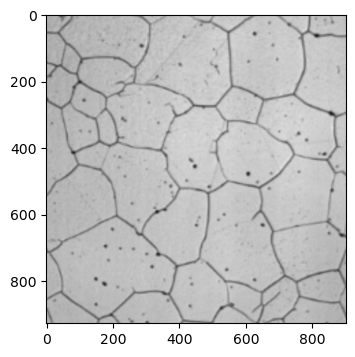

In [80]:
img = plt.imread('image')
plt.figure(figsize = (4, 4))
plt.imshow(img)


## Converting image to grayscale and smoothen using Gaussian filter

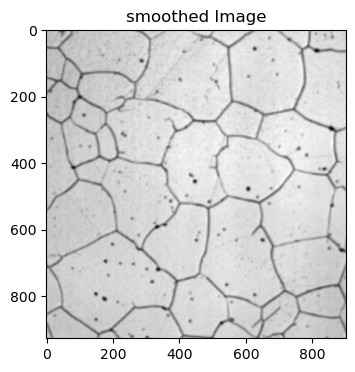

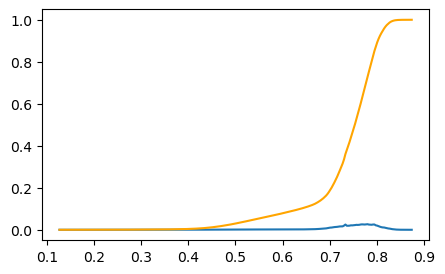

In [83]:
# Removing the alpha channel if present
if img.shape[-1] == 4:
    img = img[..., :3]  # Keep only the RGB channels

# Converting to grayscale
img1 = rgb2gray(img)

# Applying Gaussian filter to reduce noise while preserving edges
smoothed_img = gaussian_filter(img1, sigma=1)
# Displaying the smoothed_img image
plt.figure(figsize = (4, 4))
plt.imshow(smoothed_img, cmap='gray')
plt.title("smoothed Image")
plt.show()
hist, bins = histogram(smoothed_img, nbins=256)
cdf = np.cumsum(hist)

plt.figure(figsize=(5, 3))
plt.plot(bins,hist/np.sum(hist))
plt.plot(bins, cdf/np.sum(hist), color='orange')


## Finding threshold using Otsu's Thresholding Method

In [86]:
# Applying Otsu's threshold
t = filters.threshold_otsu(smoothed_img)
print(f"Otsu Threshold: {t}")


Otsu Threshold: 0.6483036913006757


## Morphological Reconstruction and Skeletonization

[[0 1 0]
 [1 1 1]
 [0 1 0]]
826


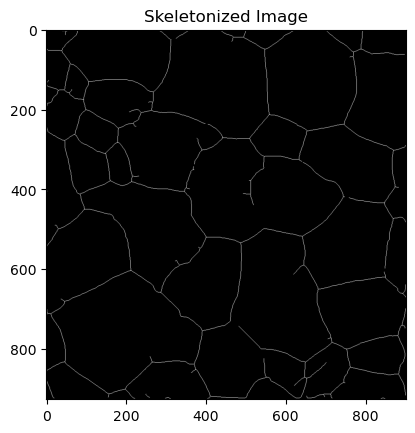

In [89]:
binary = smoothed_img <= t  # Creating binary image
selem = np.array([[0,1,0], [1,1,1], [0,1,0]])   # structuring element (cross-shaped)
print(selem)
seed = binary.copy()
seed[1:-1, 1:-1] = False
seed_last = np.full((binary.shape[0],binary.shape[1]),False)
mask = binary.copy()
n = 0
while (not np.array_equal(seed, seed_last) and n <=1000):
    n += 1
    seed_last = seed.copy()
    seed = np.logical_and(morphology.dilation(seed_last, selem),mask)
print(n)
plt.imshow(seed, cmap='gray')
seed = binary.copy()
seed[1:-1, 1:-1] = binary.min()
mask = binary.copy()
binary_final = morphology.reconstruction(seed, mask, method='dilation')
plt.imshow(binary_final, cmap='gray')
thinned = morphology.skeletonize(binary_final)
thinned = morphology.skeletonize(thinned)
plt.imshow(thinned, cmap='gray')



# Displaying the skeletonized image
plt.imshow(thinned, cmap='gray')
plt.title("Skeletonized Image")
plt.show()


## Finding triple points and labeling

Number of Filtered Triple Points: 89


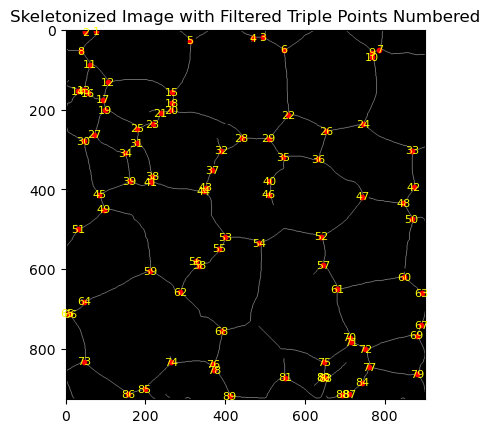

In [92]:
# Finding and displaying triple points in the skeletonized image
triple_points = np.zeros_like(thinned, dtype=bool)
for y in range(1, thinned.shape[0] - 1):
    for x in range(1, thinned.shape[1] - 1):
        if thinned[y, x]:
            neighbors = np.sum(thinned[y-1:y+2, x-1:x+2]) - 1
            if neighbors == 3:  # A triple point has at least 3 neighboring pixels
                triple_points[y, x] = True


y_coords, x_coords = np.where(triple_points)
coords = np.array(list(zip(y_coords, x_coords)))

# Applying distance-based filtering to reduce clustering
distance_threshold = 5  # Minimum distance between triple points
if len(coords) > 0:
    tree = cKDTree(coords)
    filtered_indices = tree.query_ball_point(coords, r=distance_threshold)
    unique_points = set()
    for group in filtered_indices:
        unique_points.add(group[0])  # Keep only one point per group
    filtered_coords = coords[list(unique_points)]
else:
    filtered_coords = coords

# Calculating and print the number of filtered triple points
num_filtered_triple_points = len(filtered_coords)
print(f"Number of Filtered Triple Points: {num_filtered_triple_points}")

# Displaying the filtered triple points on the skeletonized image with numbered labels
plt.imshow(thinned, cmap='gray')
plt.scatter(filtered_coords[:, 1], filtered_coords[:, 0], color='red', s=10)
for idx, (y, x) in enumerate(filtered_coords, start=1):
    plt.text(x, y, str(idx), color='yellow', fontsize=8, ha='center', va='center')
plt.title("Skeletonized Image with Filtered Triple Points Numbered")
plt.show()

## Tracking of path from triple point using Floodfill algorithm

Enter the triple point number to focus on (1-based index):  8


Triple point is: [53 38]
Found 5 white pixels: [[(53, 38), (53, 39), (52, 40), (51, 41), (50, 41), (49, 41), (48, 41), (47, 42), (46, 43), (45, 44)], [(53, 38), (54, 37), (54, 36), (54, 35), (53, 34), (53, 33), (53, 32), (53, 31), (53, 30), (53, 29)], [(53, 38), (54, 39), (55, 40), (56, 40), (57, 40), (58, 41), (59, 41), (60, 42), (61, 43), (62, 44)]]


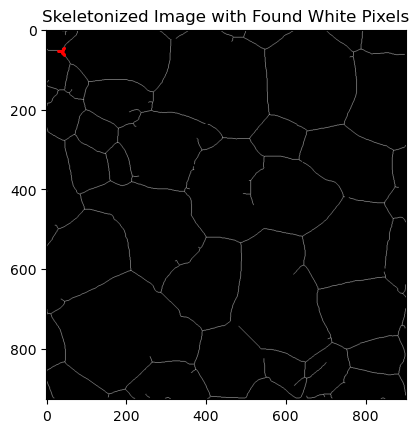

In [97]:
visited = np.zeros_like(thinned, dtype=bool)

# Prompting the user for a triple point number
point_number = int(input("Enter the triple point number to focus on (1-based index): ")) - 1
selected_triple_point = filtered_coords[point_number]

y, x = selected_triple_point
print(f"Triple point is: {selected_triple_point}")
# Marking the initial triple point as visited
visited[y, x] = True

# Finding all initial white pixels in the 3x3 neighborhood of the triple point
initial_neighbors = []
for ny in range(y - 1, y + 2):
    for nx in range(x - 1, x + 2):
        if (ny, nx) != (y, x) and 0 <= ny < thinned.shape[0] and 0 <= nx < thinned.shape[1]:
            if thinned[ny, nx] == 1:
                initial_neighbors.append((ny, nx))

                # Mark the entire 3x3 box around this pixel as visited
                for ty in range(y - 1, y + 2):
                    for tx in range(x - 1, x + 2):
                        if 0 <= ty < thinned.shape[0] and 0 <= tx < thinned.shape[1]:
                            visited[ty, tx] = True
coord = []
for center_y, center_x in initial_neighbors:
  white_pixels = []
  white_pixels.append((y, x))
  white_pixels.append((center_y, center_x))
  while len(white_pixels) < 10 :
    found_new_pixel = False  # Tracking if a new white pixel is found during this iteration

    # Iterating over the 3x3 neighborhood of the current pixel (y, x)
    neighbors_to_check = [
        (ny, nx)
        for ny in range(center_y - 1, center_y + 2)
        for nx in range(center_x - 1, center_x + 2)
        if (ny, nx) != (center_y, center_x)
    ]
    for ny in range(center_y - 1, center_y + 2):
        for nx in range(center_x - 1, center_x + 2):
            # Avoiding checking the center pixel itself, as it’s the starting point
            if (ny, nx) != (center_y, center_x):
                neighbors_to_check.append((ny, nx))

    # Looping through each neighbor to check
    for ny, nx in neighbors_to_check:
        # Ensuring the neighbor is within image bounds and is a white pixel, and has not been visited
        if 0 <= ny < thinned.shape[0] and 0 <= nx < thinned.shape[1]:
            if thinned[ny, nx] == 1 and not visited[ny, nx]:
                # Storing the white pixel coordinates
                white_pixels.append((ny, nx))
                for ty in range(center_y - 1, center_y + 2):
                    for tx in range(center_x - 1, center_x + 2):
                        if 0 <= ty < thinned.shape[0] and 0 <= tx < thinned.shape[1]:
                            visited[ty, tx] = True
                center_y,center_x = ny,nx
                break
  coord.append(white_pixels)



# Displaying the result
print(f"Found 5 white pixels: {coord}")

plt.imshow(thinned, cmap='gray')

# Looping through each list of coordinates in coord and plot each set of pixels
for white_pixel_set in coord:
    plt.scatter([x for _, x in white_pixel_set], [y for y, _ in white_pixel_set], color='red', s=1)

plt.title("Skeletonized Image with Found White Pixels")
plt.show()

## Zoomed image of a triple point

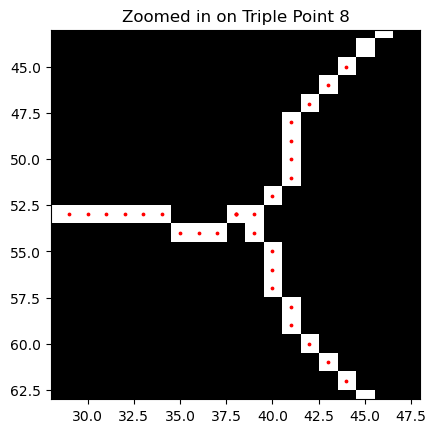

In [100]:
y, x = int(selected_triple_point[0]), int(selected_triple_point[1])

# Defining zoom window size around the selected triple point
zoom_margin = 10  # Adjust this value to increase or decrease the zoom level
y_min = max(0, y - zoom_margin)
y_max = min(thinned.shape[0], y + zoom_margin)
x_min = max(0, x - zoom_margin)
x_max = min(thinned.shape[1], x + zoom_margin)

# Ploting the zoomed-in area around the selected triple point
plt.imshow(thinned, cmap='gray')
for white_pixel_set in coord:
    plt.scatter([x for _, x in white_pixel_set], [y for y, _ in white_pixel_set], color='red', s=3)

plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)  # Reverse y-axis to match image coordinates
plt.title(f"Zoomed in on Triple Point {point_number + 1}")
plt.show()


## Finding of angles at a triple point

C:\Users\mohnish dutt\AppData\Local\Temp\ipykernel_18836\1680917211.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_with_d, x_points, y_points)


slopes of the lines are: [-1.2796610263424562, -0.021052631581174763, 1.6111111111124439]
Angle between path 1 and path 2: 129.21°
Angle between path 2 and path 3: 120.62°
Angle between path 3 and path 1: 110.17°


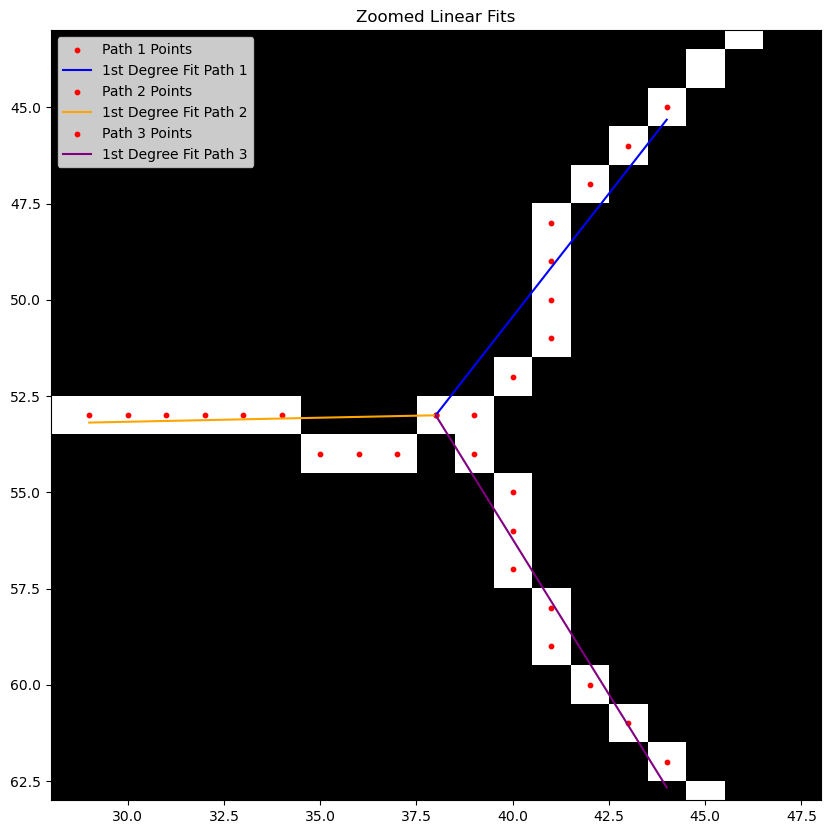

In [103]:
# Define the polynomial function (1st degree, linear)
def poly1(x, m, b):
    return m * x + b

# Constrained polynomial function to ensure it passes through the triple point
def constrained_poly(x, m, b, d_fixed):
    return poly1(x, m, b) + d_fixed

# Initialize plot
plt.figure(figsize=(10, 10))
plt.imshow(thinned, cmap='gray')
ang = []  # List to store angles for each path
colors = ['blue', 'orange', 'purple']  # Colors for different paths
slopes = []  # List to store slopes of paths for angle calculations

# Fit the paths and compute angles
for i, white_pixel_set in enumerate(coord):
    x_points = [x for _, x in white_pixel_set]
    y_points = [y for y, _ in white_pixel_set]

    # Fit the linear polynomial for the current path
    def fit_with_d(x, m, b):
        d = selected_triple_point[0] - (m * selected_triple_point[1] + b)
        return constrained_poly(x, m, b, d)

    popt, _ = curve_fit(fit_with_d, x_points, y_points)

    # Generate x values for plotting
    x_fit = np.linspace(min(x_points), max(x_points), 100)
    y_fit = fit_with_d(x_fit, *popt)

    # Plot original points and fitted curve
    plt.scatter(x_points, y_points, color='red', s=10, label=f'Path {i+1} Points')
    plt.plot(x_fit, y_fit, color=colors[i % len(colors)], label=f'1st Degree Fit Path {i+1}')
     # Calculate angle (in degrees) of the fit from horizontal (x-axis)
    m = popt[0]  # Slope of the fitted line

    if m > 0:
        angle = np.degrees(np.arctan(m))  # For positive slopes
    else:
        angle = np.degrees(np.arctan(m)) + 180  # For negative slopes, add 180 to ensure it is between 0 and 180 degrees

    # Adjust for vertical lines (slopes approaching infinity)
    if np.isinf(m):  # Handle vertical lines
        angle = 90 if m > 0 else 270

    ang.append(angle)
    slopes.append(m)  # Store slope for each path

    # Annotate the plot with the angle
    mid_x = np.mean(x_points)  # Use the middle of the points for annotation
    mid_y = np.mean(y_points)


# Calculate angles between paths (1-2, 2-3, 3-1)
def angle_between_lines(m1, m2):
        return np.degrees(np.arctan(((m1 - m2) / (1 + m1 * m2))))

# Compute angles between paths
angle_1_2 = angle_between_lines(slopes[0], slopes[1])
angle_2_3 = angle_between_lines(slopes[1], slopes[2])
angle_3_1 = angle_between_lines(slopes[2], slopes[0])
print(f"slopes of the lines are: {slopes}")
# Print the angles between the paths
print(f"Angle between path 1 and path 2: {180-abs(angle_1_2):.2f}°")
print(f"Angle between path 2 and path 3: {180-abs(angle_2_3):.2f}°")
print(f"Angle between path 3 and path 1: {180-abs(angle_3_1):.2f}°")


# Set plot limits and labels
plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)
plt.title("Zoomed Linear Fits")
plt.legend()
plt.show()


## Distribution of angles at triple points

C:\Users\mohnish dutt\AppData\Local\Temp\ipykernel_18836\1273770703.py:75: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_with_d, x_points, y_points)


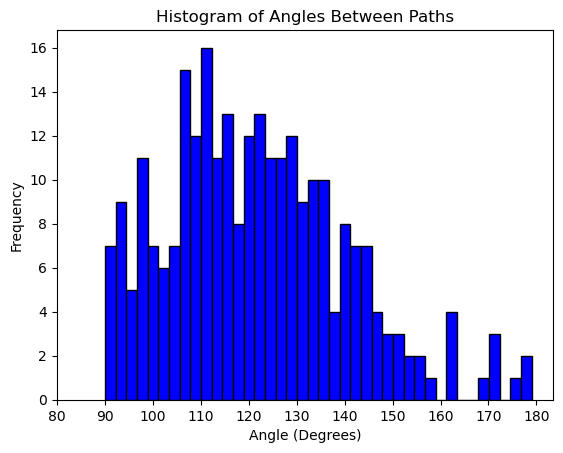

In [106]:
# Define the polynomial function (1st degree, linear)
def poly1(x, m, b):
    return m * x + b

# Constrained polynomial function to ensure it passes through the triple point
def constrained_poly(x, m, b, d_fixed):
    return poly1(x, m, b) + d_fixed

# Initialize the angles list
angles_all_points = []

# Loop through each triple point
for point_number, selected_triple_point in enumerate(filtered_coords):
    y, x = selected_triple_point
    visited = np.zeros_like(thinned, dtype=bool)  # Reset visited matrix for each triple point

    # Mark the initial triple point as visited
    visited[y, x] = True

    # Find all initial white pixels in the 3x3 neighborhood of the triple point
    initial_neighbors = []
    for ny in range(y - 1, y + 2):
        for nx in range(x - 1, x + 2):
            if (ny, nx) != (y, x) and 0 <= ny < thinned.shape[0] and 0 <= nx < thinned.shape[1]:
                if thinned[ny, nx] == 1:
                    initial_neighbors.append((ny, nx))
                    visited[ny, nx] = True

    # Trace paths from initial neighbors
    coord = []
    for center_y, center_x in initial_neighbors:
        white_pixels = []
        white_pixels.append((y, x))
        white_pixels.append((center_y, center_x))
        max_iterations = 20
        iterations = 0
        while len(white_pixels) < 10 and iterations < max_iterations:
            iterations += 1
            found_new_pixel = False
            neighbors_to_check = [
                (ny, nx)
                for ny in range(center_y - 1, center_y + 2)
                for nx in range(center_x - 1, center_x + 2)
                if (ny, nx) != (center_y, center_x)
            ]
                      
            for ny, nx in neighbors_to_check:
                if 0 <= ny < thinned.shape[0] and 0 <= nx < thinned.shape[1]:
                   if thinned[ny, nx] == 1 and not visited[ny, nx]:
                      white_pixels.append((ny, nx))
                      # for ty in range(center_y - 1, center_y + 2):
                      #   for tx in range(center_x - 1, center_x + 2):
                      #       if 0 <= ty < thinned.shape[0] and 0 <= tx < thinned.shape[1]:
                      visited[ny, nx] = True
                      center_y,center_x = ny,nx
                      found_new_pixel = True
                      break
            if not found_new_pixel:
                break
        if len(white_pixels) >= 2:
          coord.append(white_pixels)

    # Fit lines to the white pixel sets and calculate slopes
    slopes = []
    for i, white_pixel_set in enumerate(coord):
        
        x_points = [x for _, x in white_pixel_set]
        y_points = [y for y, _ in white_pixel_set]

        # Fit the linear polynomial for the current path
        def fit_with_d(x, m, b):
            d = selected_triple_point[0] - (m * selected_triple_point[1] + b)
            return constrained_poly(x, m, b, d)

        popt, _ = curve_fit(fit_with_d, x_points, y_points)

        # Generate x values for plotting
        x_fit = np.linspace(min(x_points), max(x_points), 100)
        y_fit = fit_with_d(x_fit, *popt)

        # Calculate angle (in degrees) of the fit from horizontal (x-axis)
        m = popt[0]  # Slope of the fitted line

        if m > 0:
            angle = np.degrees(np.arctan(m))  # For positive slopes
        else:
            angle = np.degrees(np.arctan(m)) + 180  # For negative slopes, add 180 to ensure it is between 0 and 180 degrees

        # Adjust for vertical lines (slopes approaching infinity)
        if np.isinf(m):  # Handle vertical lines
            angle = 90 if m > 0 else 270

        slopes.append(m)  # Store slope for each path

        # Annotate the plot with the angle
        mid_x = np.mean(x_points)  # Use the middle of the points for annotation
        mid_y = np.mean(y_points)

    # Calculate angles between paths (1-2, 2-3, 3-1)
    def angle_between_lines(m1, m2):
        return np.degrees(np.arctan(((m1 - m2) / (1 + m1 * m2))))

    # Calculate angles between the slopes
    angles_all_points.append(180 - abs(angle_between_lines(slopes[0], slopes[1])))
    angles_all_points.append(180 - abs(angle_between_lines(slopes[1], slopes[2])))
    angles_all_points.append(180 - abs(angle_between_lines(slopes[2], slopes[0])))



# Plotting the histogram of angles
plt.hist(angles_all_points, bins=40, color='blue', edgecolor='black')
plt.title('Histogram of Angles Between Paths')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Frequency')
plt.xticks(range(80, 181, 10))
plt.show()


### All angles lies between 90 to 180 degrees